<a href="https://colab.research.google.com/github/Sabaudian/Neural_Conversational_Agents_project/blob/main/build_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import

In [ ]:
# === Install === #
!pip install -q torch
!pip install -q bert_score
!pip install -q rouge_score
!pip install -q transformers
!pip install -q huggingface_hub[hf_xet]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 MB 13.9 MB/s eta 0:00:00


In [ ]:
# === Version Controls === #
import torch
import transformers

print("LIBRARY: \t| VERSION:")
print(f"> PyTorch\t| {torch.__version__}")
print(f"> Transformers\t| {transformers.__version__}")


LIBRARY: 	| VERSION:
> PyTorch	| 2.6.0+cu124
> Transformers	| 4.51.3


In [ ]:
# === Import === #

# General
import os
import csv
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import chain
from google.colab import drive
from tqdm.notebook import tqdm, trange
from typing import Any, Dict, List, Optional, Tuple
from sklearn.model_selection import train_test_split

from bert_score import score
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu

# Torch
import torch.nn.functional as F

from torch.optim import AdamW
from torch.nn.utils.rnn import pad_sequence
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader, Dataset, RandomSampler

# Transformers
from transformers import (
    AutoConfig,
    AutoModelWithLMHead,
    AutoModelForCausalLM,
    AutoTokenizer,
    PreTrainedModel,
    PreTrainedTokenizer,
    get_linear_schedule_with_warmup,
    AutoModelForSequenceClassification,
    pipeline,
)


In [ ]:
# === Constants & Set-Up === #

# Google Drive Paths
drive.mount("/content/drive")                              # Mount Google Drive
DRIVE_BASE_DIR = "/content/drive/MyDrive/Colab_Notebooks"  # Path to Drive main directory

# Directories & Paths
DATA_DIR = os.path.join(DRIVE_BASE_DIR, "data")     # Path to data directory
OUTPUT_DIR = os.path.join(DRIVE_BASE_DIR, "output") # Path to output directory (training result)
PLOT_DIR = os.path.join(DRIVE_BASE_DIR, "plots")    # Path to plots directory
METRICS_DIR = os.path.join(DATA_DIR, "metrics")     # Path to metrics directory

# Paths to datasets used for training or evaluation
DATASETS = {
    "cornell": os.path.join(DATA_DIR, "cornell"),          # cornell movie-corpus dataset
    "Joey": os.path.join(DATA_DIR, "friends", "Joey"),     # Joey dataset (from Friends dataset)
    "Phoebe": os.path.join(DATA_DIR, "friends", "Phoebe")  # Phoebe dataset (from Friends dataset)
}
DATASETS_ID = ["cornell", "Joey", "Phoebe"]                # Dataset identifiers for iteration or selection

# Pre-trained conversational model
MODEL_NAME = "microsoft/DialoGPT-small"             # Name of the Hugging Face pre-trained model to load
EXCLUDED_FROM_DECAY = ["bias", "LayerNorm.weight"]  # Parameters to exclude from weight decay during training
DEFAULT_PADDING_SIDE = "left"                       # Padding direction for tokenized inputs (GPT models require left padding)

# Training and Hyperparameters
INPUT_SIZE = 512                    # Maximum sequence length for input text
DO_TRAIN = True                     # Whether to perform training
DO_EVAL = True                      # Whether to perform evaluation

TRAIN_BATCH_SIZE = 8                # Batch size for training
EVAL_BATCH_SIZE = 16                # Batch size for evaluation
GRADIENT_ACCUMULATION_STEPS = 1     # Number of steps to accumulate gradients before updating
LEARNING_RATE = 2e-5                # Initial learning rate for the optimizer
WEIGHT_DECAY = 0.01                 # Weight decay for the optimizer
ADAM_EPSILON = 1e-8                 # Epsilon value for the Adam optimizer
MAX_GRAD_NORM = 1.0                 # Maximum norm for gradient clipping
NUM_EPOCHS = 5                      # Number of training epochs
WARMUP_STEPS = 0.01                 # Number of steps for learning rate warm-up
MAX_TARGET_LENGTH = 50              # Maximum length of the generated response/output sequence
SEED = 42                           # Random seed for reproducibility
LOCAL_RANK = -1                     # Rank of the process for distributed training (-1 for non-distributed)

# Type Alias
TorchDataset = torch.utils.data.Dataset             # Alias for PyTorch dataset type
TorchOptimizer = torch.optim.Optimizer              # Alias for PyTorch optimizer type
TorchScheduler = torch.optim.lr_scheduler.LambdaLR  # Alias for a learning rate scheduler (LambdaLR in this case)

# Warnings Set-up
warnings.filterwarnings("ignore") # Suppress warnings for cleaner output during execution

# Emotion Classification Model & Labels
EMOTION_MODEL = "j-hartmann/emotion-english-distilroberta-base"                        # Pre-trained model for emotion classification
EMOTION_LABELS = ["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"] # Emotion labels


Mounted at /content/drive


In [ ]:
# === Check available device === #
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"> Device: {device}")

# Print GPU info.
if device.type == "cuda":
    !nvidia-smi
else:
    print("> WARNING no gpu available! Running via gpu is highly recommended.")


> Device: cuda
Sat May 10 08:28:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P8             11W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+--------------------------------

In [ ]:
# === Define Working environment === #
def makedirs(dir_path: str) -> None:
    """
    Create a directory if it doesn't exist.

    Args:
        path: Path to the directory to be created.
    """
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print(f"> Directory '{dir_path}' created.")
    else:
        print(f"> Directory '{dir_path}' already exists.")


# Define environmental directories
for path in [OUTPUT_DIR, PLOT_DIR, METRICS_DIR]:
    makedirs(dir_path=path)

# Define specific directories by datasets id
for id in DATASETS_ID:
    makedirs(dir_path=os.path.join(OUTPUT_DIR, f"{id}"))


## Load Data

In [ ]:
# Load dataset splits
def load_dataset(name: str) -> Dict:
    """
    Load the dataset selected by name.

    Args:
        name: Name of the dataset to load.

    Returns:
        dataset_dict: A dictionary containing train, valid, and test DataFrames.
    """
    path = DATASETS[name]

    dataset_dict = {
        "train": pd.read_csv(os.path.join(path, f"{name}_train.csv")),
        "valid": pd.read_csv(os.path.join(path, f"{name}_valid.csv")),
        "test": pd.read_csv(os.path.join(path, f"{name}_test.csv"))
    }
    return dataset_dict


In [ ]:
# # Load datasets
# cornell_data = load_dataset("cornell")
# joey_data = load_dataset("Joey")
# phoebe_data = load_dataset("Phoebe")

# # Cornell Movie-corpus dataset
# cornell_train_set = cornell_data["train"]
# cornell_valid_set = cornell_data["valid"]
# cornell_test_set = cornell_data["test"]

# # (Friends) Joey dataset
# joey_train_set = joey_data["train"]
# joey_valid_set = joey_data["valid"]
# joey_test_set = joey_data["test"]

# # (Friends) Phoebe dataset
# phoebe_train_set = phoebe_data["train"]
# phoebe_valid_set = phoebe_data["valid"]
# phoebe_test_set = phoebe_data["test"]


## Utils

### Tokenization

In [ ]:
# Tokenize and flatten a conversation into a single sequence
def tokenize_and_flatten_conversation(dialogue_turns: List[str], tokenizer: PreTrainedTokenizer) -> List[int]:
  """
  Encodes a conversation into a single flattened sequence of tokens.

  - Each dialogue turn is encoded and appended with an EOS token.
  - The conversation is reversed so the most recent utterance comes first,
      which is beneficial for causal models to focus on the most recent context.

  Args:
      dialogue_turns: List of dialogue turns in a conversation.
      tokenizer: Tokenizer for encoding text.

  Returns:
      Flattened sequence of token IDs with EOS tokens appended.
  """
  reversed_turns = reversed(dialogue_turns) # Reverse order so latest turns are earlier

  tokenized_turns = [
      tokenizer.encode(turn, truncation=True, max_length=tokenizer.model_max_length) + [tokenizer.eos_token_id]
      for turn in reversed_turns
  ]
  tokenized_conversation = list(chain.from_iterable(tokenized_turns))
  return tokenized_conversation


### Build Conversation Dataset

In [ ]:
# PyTorch-compatible dataset
class ConversationDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, tokenizer: PreTrainedTokenizer):
        """
        Initializes a dataset object by preprocessing and tokenizing dialogue rows.

        - Adjusts block size to avoid model-specific overflow.
        - Iterates through the DataFrame and tokenizes each conversation.
        - Filters out overly long sequences to maintain uniformity in batch sizes.

        Args:
            dataframe: DataFrame of context-response rows.
            tokenizer: Tokenizer used to convert text to token IDs.
        """
        # Adjust block size for tokenizer-specific constraints
        tokenizer_adjusted_block_size = min(INPUT_SIZE, tokenizer.model_max_length)

        self.examples = []

        for _, row in dataframe.iterrows():
            # Tokenize all dialogue turns (row is a Series of context columns + response)
            conversation = tokenize_and_flatten_conversation(
                dialogue_turns=row.dropna().astype(str).tolist(), tokenizer=tokenizer
            )
            # Keep only conversations within the allowed length
            if len(conversation) <= tokenizer_adjusted_block_size:
                self.examples.append(conversation)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, item):
        # Return a token sequence as a PyTorch tensor
        example = self.examples[item]
        return torch.tensor(example, dtype=torch.long)


# Builds a ConversationDataset instance
def build_conversation_dataset(tokenizer: PreTrainedTokenizer, df: pd.DataFrame) -> ConversationDataset:
    """
    Selects the correct DataFrame and builds a dataset object.

    Args:
        tokenizer: The tokenizer.
        df: Selected dataframe.

    Returns:
        A ConversationDataset instance.
    """
    new_instance = ConversationDataset(dataframe=df, tokenizer=tokenizer)

    return new_instance


### Data Loading

In [ ]:
# Ensures reproducibility
def set_seed() -> None:
    """Ensure deterministic behavior across runs."""
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)


# Pads a batch of sequences to the maximum length in the batch
def collate_function(examples: List[torch.Tensor], tokenizer: PreTrainedTokenizer) -> torch.Tensor:
    """
    Collates a batch of variable-length token sequences into a uniform batch with padding.

    Args:
        examples: List of token tensors.
        tokenizer: Tokenizer with pad token information.

    Returns:
        A single padded batch tensor of shape (batch_size, max_seq_len).
    """
    if tokenizer.pad_token is not None:
        return pad_sequence(
            examples, batch_first=True, padding_value=tokenizer.pad_token_id
        )
    else:
        return pad_sequence(examples, batch_first=True)


# Builds a PyTorch DataLoader for training or evaluation
def get_dataloader(dataset: TorchDataset, tokenizer: PreTrainedTokenizer, is_training: bool) -> DataLoader:
    """
    Creates a DataLoader object, using a sampler compatible with single or multi-GPU training.

    Args:
        dataset: Preprocessed dataset object.
        tokenizer: Tokenizer used for collate function.
        is_training: Flag to set batch size and sampler mode.

    Returns:
        A DataLoader instance ready for training or evaluation.
    """
    # Choose sampler type: Random for single GPU
    # sampler = RandomSampler(data_source=dataset)

    # Determine appropriate batch size
    batch_size = TRAIN_BATCH_SIZE if is_training else EVAL_BATCH_SIZE
    shuffle_tag = True if is_training else False

    # Return DataLoader
    return DataLoader(
        dataset=dataset,
        # sampler=sampler,
        batch_size=batch_size,
        collate_fn=lambda examples: collate_function(
            examples=examples, tokenizer=tokenizer
        ),
        shuffle=shuffle_tag,
        num_workers=2,
        pin_memory=True,
    )


### Optimizer and Scheduler Configuration

In [ ]:
# Prepares optimizer and scheduler
def configure_optimizer_scheduler(model: PreTrainedModel, total_training_steps: int) -> Tuple[TorchOptimizer, TorchScheduler]:
    """
    Sets up AdamW optimizer and linear learning rate scheduler.

    - Applies weight decay to all layers except specified exclusions.
    - Uses linear decay with warmup steps to stabilize early training.

    Args:
        args: Config object.
        model: Transformer model with named parameters.
        total_training_steps: Total steps across all epochs.

    Returns:
        Tuple of (optimizer, scheduler).
    """
    optimizer_groups = [
        {
            "params": [
                p for n, p in model.named_parameters()
                if not any(exclusion in n for exclusion in EXCLUDED_FROM_DECAY)
            ],
            "weight_decay": WEIGHT_DECAY,
        },
        {
            "params": [
                p for n, p in model.named_parameters()
                if any(exclusion in n for exclusion in EXCLUDED_FROM_DECAY)
            ],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(
        params=optimizer_groups, lr=LEARNING_RATE, eps=ADAM_EPSILON,
    )

    scheduler = get_linear_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=int(total_training_steps * WARMUP_STEPS),
        num_training_steps=total_training_steps,
    )
    return optimizer, scheduler


### Model & Tokenizer I/O

In [ ]:
# Loads a pre-trained model and tokenizer
def load_model_and_tokenizer(model_path: str, tokenizer_path: str) -> Tuple[PreTrainedModel, PreTrainedTokenizer]:
    """
    Loads a pre-trained transformer model and tokenizer from specified paths.

    Args:
        model_path: Directory path to the model.
        tokenizer_path: Directory path to the tokenizer.

    Returns:
        Tuple of (model, tokenizer).
    """
    # configuration
    config = AutoConfig.from_pretrained(
        pretrained_model_name_or_path=model_path,
        gradient_checkpointing=True
    )

    # Tokenizer
    tokenizer = AutoTokenizer.from_pretrained(
        pretrained_model_name_or_path=tokenizer_path,
        config=config,
    )
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = DEFAULT_PADDING_SIDE

    # Model
    model = AutoModelForCausalLM.from_pretrained(
        pretrained_model_name_or_path=model_path,
        config=config,
    )
    model.to(device)

    return model, tokenizer


# Saves model and tokenizer after training
def save_model_and_tokenizer(model: PreTrainedModel, tokenizer: PreTrainedTokenizer, data_id: str) -> None:
    """
    Save the final model and tokenizer to the output directory.

    Args:
        model: Fine-tuned transformer model.
        tokenizer: Associated tokenizer.
        data_id: identify the data to save to correct location.
    """
    save_path = os.path.join(OUTPUT_DIR, data_id)
    print(f"\n> Saving model to: {save_path}")

    model.config.save_pretrained(save_path)
    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)


### Metrics

In [ ]:
# Save training metrics
def training_scores_to_csv(data_id: str, **metrics: list) -> None:
    """
    Save metrics calculated during training to a CSV file.

    Args:
        data_id: Identify the dataset to save to correct location.
        **metrics: Named metric lists (e.g., Train_Loss, Val_Loss).
    """
    metrics_df = pd.DataFrame({"Epoch": list(range(1, NUM_EPOCHS + 1))})

    # Add each metric to the DataFrame
    for name, values in metrics.items():
        metrics_df[name.replace("_", " ")] = [round(v, 4) for v in values]

    csv_path = os.path.join(METRICS_DIR, f"{data_id}_training_metrics.csv")
    metrics_df.to_csv(path_or_buf=csv_path, index=False)

    print(f"\n> Metrics saved to: {csv_path}")


# Compute BLEU and ROUGE-L Scores
def compute_bleu_rouge(references: List[str], predictions: List[str]) -> Dict[str, float]:
    """
    Computes BLEU and ROUGE-L scores for model evaluation.

    Args:
        references: List of ground truth responses.
        predictions: List of generated responses.

    Returns:
        BLEU and ROUGE-L scores.
    """
    references = [str(ref) for ref in references]

    # BLEU
    bleu_scores = [sentence_bleu([ref.split()], pred.split()) for ref, pred in zip(references, predictions)]
    avg_bleu = sum(bleu_scores) / len(bleu_scores)

    # ROUGE-L
    rouge_scorer_instance = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
    rouge_l_scores = [rouge_scorer_instance.score(ref, pred)["rougeL"].fmeasure for ref, pred in zip(references, predictions)]
    avg_rouge_l = sum(rouge_l_scores) / len(rouge_l_scores)

    # BERTScore (F1)
    P, R, F1 = score(predictions, references, lang="en", rescale_with_baseline=True)
    avg_bert_f1 = F1.mean().item()

    return {
        "BLEU": avg_bleu,
        "ROUGE-L": avg_rouge_l,
        "BERTScore-F1": avg_bert_f1
    }


# Store evaluation mtrics
def bleu_rouge_scores_to_csv(data_id: str, bleu: float, rouge: float) -> None:
    """
    Save BLEU and ROUGE to a CSV file.

    Args:
        predictions: Generated responses from the model.
        references: Ground truth responses.
        save_path: Path to the output CSV file.
    """
    df = pd.DataFrame({
        "BLEU": [bleu],
        "ROGUE-L": [rouge],
    })
    csv_path = os.path.join(METRICS_DIR, f"{data_id}_predicts_metrics.csv")
    df.to_csv(path_or_buf=csv_path, index=False)

    print(f"\n> Metrics saved to: {csv_path}")



### Plot Functions

In [ ]:
# Plot average training/validation loss per epoch
def plot_loss(csv_path: str, save_path: str) -> None:
    """
    Plot Train and Val loss across epochs.

    Args:
        csv_path: Path to the CSV file containing metrics.
        save_path: Path to save the resulting plot image.
    """
    # Load data
    df = pd.read_csv(csv_path)

    # Plot
    plt.figure(figsize=(10, 6))

    # Train loss
    plt.plot(
        df["Epoch"], df["Train Loss"],
        marker="o", linestyle="-",
        color="royalblue", linewidth=2,
        label="Avg. Training Loss"
    )

    # Val loss
    plt.plot(
        df["Epoch"], df["Val Loss"],
        marker="s", linestyle="--",
        color="orange", linewidth=2,
        label="Avg. Validation Loss"
    )

    # Labels, title, and grid
    plt.title("Training and Validation Loss per Epoch", fontsize=16)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.grid(True, linestyle='-', alpha=0.6)
    plt.xticks(df["Epoch"])
    plt.legend(fontsize=12)
    plt.tight_layout()

    plt.savefig(save_path)  # Save the plot
    plt.show() # Show the plot


# Plot average perplexity per epoch
def plot_perplexity(csv_path: str, save_path: str) -> None:
    """
    Plot Perplexity across epochs.

    Args:
        csv_path: Path to the CSV file containing metrics.
        save_path: Path to save the resulting plot image.
    """
    # Load data
    df = pd.read_csv(csv_path)

    # Plot
    plt.figure(figsize=(10, 6))

    # Perplexity
    plt.plot(
        df["Epoch"], df["Perplexity"],
        marker="o", linestyle="-",
        color="forestgreen", linewidth=2,
        label="Avg. Perpexity"
    )

    # Labels, title, and grid
    plt.title("Perplexity scores per Epoch", fontsize=16)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Perplexity", fontsize=14)
    plt.grid(True, linestyle='-', alpha=0.6)
    plt.xticks(df["Epoch"])
    plt.legend(fontsize=12)
    plt.tight_layout()

    plt.savefig(save_path)  # Save the plot
    plt.show() # Show the plot


# Plot Emotion radar
def plot_emotion_radar(ref_avg: np.ndarray, pred_avg: np.ndarray, labels: list, id: str, save_path: str) -> None:
    """
    Plot reference and predicted average emotion scores as a radar chart.

    Args:
        ref_avg: Array of average emotion scores from the reference texts.
        pred_avg: Array of average emotion scores from the predicted texts.
        labels: List of emotion label names corresponding to the score dimensions.
        id: Identify the dataset.
        save_path: File path to save the generated radar plot.
    """
    # Filter out "neutral" from labels and scores
    filtered = [(label, r, p) for label, r, p in zip(labels, ref_avg, pred_avg) if label != "neutral"]
    filtered_labels, ref_avg, pred_avg = zip(*filtered)
    ref_avg = np.array(ref_avg)
    pred_avg = np.array(pred_avg)

    # Compute angles for radar chart (one per emotion label)
    angles = np.linspace(0, 2 * np.pi, len(filtered_labels), endpoint=False).tolist()
    angles += angles[:1]
    # Close the radar chart by repeating the first value at the end
    ref_avg = np.append(ref_avg, ref_avg[0])
    pred_avg = np.append(pred_avg, pred_avg[0])

    # Define radar plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

     # Plot reference line
    ax.plot(angles, ref_avg, color="blue", linewidth=2, label="Reference")
    ax.fill(angles, ref_avg, color="blue", alpha=0.25)
    # Plot prediction line
    ax.plot(angles, pred_avg, color="red", linewidth=2, label="Prediction")
    ax.fill(angles, pred_avg, color="red", alpha=0.25)

    # Set label
    ax.set_thetagrids(np.degrees(angles[:-1]), filtered_labels)
    ax.set_title(f"{id} - Emotion Spectrum", size=16, pad=30)
    ax.legend(loc="best", bbox_to_anchor=(1.1, 1.1))

    plt.savefig(save_path)  # Save the plot
    plt.show() # Show the plot


## Training

In [ ]:
# === Training and Validation Steps === #

# Training Step
def training_step(model: PreTrainedModel, optimizer: TorchOptimizer, scheduler: TorchScheduler, dataloader: DataLoader, scaler: GradScaler) -> float:
    """
    Executes a single epoch of training.

    Args:
        model: The model being trained.
        optimizer: The optimizer used for training.
        scheduler: Learning rate scheduler.
        dataloader: The DataLoader for training data.
        scaler: GradScaler for mixed precision training.

    Returns:
        Average loss for the epoch.
    """
    model.train() # Set model in training mode
    loss_counter = 0.0 # Initialize counter

    # Iterate through training batches with a progress bar
    epoch_iterator = tqdm(dataloader, desc="Training Progress")

    for step, batch in enumerate(epoch_iterator):
        # In causal LM, inputs = labels
        inputs = batch.to(device) # Move input to the designated device

        with autocast():
            outputs = model(inputs, labels=inputs) # Forward pass with loss computation
            loss = outputs.loss # Extract scalar loss value
        scaler.scale(loss).backward() # Backpropagation
        loss_counter += loss.item() # Accumulate loss for average computation

        # Perform optimization step every gradient_accumulation_steps
        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            current_lr = scheduler.get_last_lr()[0] # Get current learning rate
            epoch_iterator.set_postfix({"loss": loss.item(), "lr": current_lr})
            # Gradient clipping to stabilize training
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
            # Update model parameters
            scaler.step(optimizer)
            scaler.update()
             # Update learning rate
            scheduler.step()
            # Reset gradients
            model.zero_grad()
    # Average loss
    avg_train_loss = loss_counter / len(dataloader)

    return avg_train_loss


# Validation Step
def validation_step(model: PreTrainedModel, dataloader: DataLoader) -> Tuple[float, float]:
    """
    Executes a single validation step.

    Args:
        model: The model being evaluated.
        dataloader: The DataLoader for validation data.

    Returns:
        Loss for the validation step.
        Perplexity for the validation step.
    """
    # Set model in evaluation mode
    model.eval()

    loss_counter = 0.0
    perplexity_counter = 0.0

    # Iterate through validation batches with a progress bar
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation Progress"):
            # In causal LM, inputs = labels
            inputs = batch.to(device) # Move input to the designated device
            outputs = model(input_ids=inputs, labels=inputs) # Forward pass with loss computation
            loss_counter += outputs.loss.item()
            perplexity_counter += torch.exp(outputs.loss).item()

    # Average validation loss
    avg_val_loss = loss_counter / len(dataloader)
    # Average perplexity
    avg_perplexity = perplexity_counter / len(dataloader)

    return avg_val_loss, avg_perplexity


# === Complete Training Process === #
def perform_training_process(model: PreTrainedModel, tokenizer: PreTrainedTokenizer, train_set: ConversationDataset, valid_set: ConversationDataset, id: str) -> None:
    """
    Executes full training loop across multiple epochs.

    Args:
        model: The model to be trained.
        tokenizer: The employed tokenizer.
        train_dataset: The dataset for training.
        valid_dataset: The dataset for validation.
        id: Identify the dataset to save to correct location.

    Returns:
        Average Training/Validation Loss and Average Perplexity.
    """
    # Train DataLoader
    train_dataloader = get_dataloader(
        dataset=train_set,
        tokenizer=tokenizer,
        is_training=True,
    )
    # Validation DataLoader
    valid_dataloader = get_dataloader(
        dataset=valid_set,
        tokenizer=tokenizer,
        is_training=False,
    )

    # Calculate total number of optimization steps
    total_steps = len(train_dataloader) * NUM_EPOCHS
    # Resize model embeddings in case tokenizer has been extended
    model.resize_token_embeddings(new_num_tokens=len(tokenizer))

    # Initialize optimizer and scheduler
    optimizer, scheduler = configure_optimizer_scheduler(
        model=model,
        total_training_steps=total_steps,
    )
    scaler = GradScaler()
    set_seed() # Set seed for reproducibility

    print("\n>> START TRAINING PROCESS")
    print(f" -- Training Examples: {len(train_dataloader)}")
    print(f" -- Validation Examples: {len(valid_dataloader)}")
    print(f" -- Number of Epochs: {NUM_EPOCHS}\n")

    # Store metrics
    train_losses = [] # Train Loss per epoch storing (used by plot)
    valid_losses = [] # Valid Loss per epoch storing (used by plot)
    perplexities = [] # Perplexity per epoch storing

    # Iterator
    train_iterator = trange(NUM_EPOCHS, desc="Epoch Iteration")

    # Main training loop over all epochs
    for epoch in train_iterator:
        print(f"\n> Epoch {epoch+1}/{NUM_EPOCHS}")

        # Training
        train_loss = training_step(
            model=model,
            optimizer=optimizer,
            scheduler=scheduler,
            dataloader=train_dataloader,
            scaler=scaler,
        )
        train_losses.append(train_loss)

        # Validation
        val_loss, perplexity = validation_step(
            model=model, dataloader=valid_dataloader
        )
        valid_losses.append(val_loss)
        perplexities.append(perplexity)

        print(f"\n  - Training Loss: {train_loss:.4f}")
        print(f"  - Validation Loss: {val_loss:.4f}")
        print(f"  - Perplexity: {perplexity:.4f}")

    # Avg. Metrics values through all epochs
    avg_training_loss = sum(train_losses) / len(train_losses)
    avg_validation_loss = sum(valid_losses) / len(valid_losses)
    avg_perplexity = sum(perplexities) / len(perplexities)

    print(
        f"\n> Avg. Train Loss: {avg_training_loss:.4f}, "
        f"Avg. Val Loss: {avg_validation_loss:.4f}, "
        f"Avg. Perplexity: {avg_perplexity:.4f}."
    )
    # Save to csv
    training_scores_to_csv(
        data_id=id, Train_Loss=train_losses, Val_Loss=valid_losses, Perplexity=perplexities
    )
    # Save trained model and tokenizer
    save_model_and_tokenizer(model=model, tokenizer=tokenizer, data_id=id)


### Train all dataset

In [ ]:
# Execute the training process on all dataset
def execute_training_on_all_dataset() -> None:
    """
    Execute the training process on all datasets.

    Args:
        train_df: Training DataFrame.
        val_df: Validation DataFrame.
    """
    # Load pre-trained model and tokenizer
    model, tokenizer = load_model_and_tokenizer(
        tokenizer_path=MODEL_NAME,
        model_path=MODEL_NAME,
    )
    model.to(device)

    # Train model on every dataset
    for id in DATASETS_ID:
        print(f"\n>> Training on {id} data...")

        # Load dataset splits
        dataset_splits = load_dataset(name=id)
        train_df = dataset_splits["train"]
        val_df = dataset_splits["valid"]

        # Training Dataset
        training_dataset = build_conversation_dataset(
            tokenizer=tokenizer,
            df=train_df,
        )
        # Validation Dataset
        validation_dataset = build_conversation_dataset(
            tokenizer=tokenizer,
            df=val_df,
        )
        # Training Process
        perform_training_process(
            model=model,
            tokenizer=tokenizer,
            train_set=training_dataset,
            valid_set=validation_dataset,
            id=id,
        )

        # Plot loss and Perplexity
        csv_path = os.path.join(METRICS_DIR, f"{id}_training_metrics.csv")
        plot_loss_path = os.path.join(PLOT_DIR, f"{id}_train_val_loss_plot.png")
        plot_perplexity_path = os.path.join(PLOT_DIR, f"{id}_perplexity_plot.png")

        plot_loss(csv_path=csv_path, save_path=plot_loss_path)
        plot_perplexity(csv_path=csv_path, save_path=plot_perplexity_path)

        print(f"-"*30) # Separation line for readability
        print() # Empty line for readability


In [ ]:
# === Traning Execution on all data === #
execute_training_on_all_dataset()


### Choose which dataset to train

In [ ]:
# Execute the training process on a single selected datset
def execute_training_on_single_dataset(dataset_id: str) -> None:
    """
    Execute the training process on a single dataset.

    Args:
        dataset_id: ID of the dataset to be used.
    """
    if dataset_id not in DATASETS_ID:
        raise ValueError(f"Unknown dataset_id: {dataset_id}")

    # Load dataset splits
    dataset_splits = load_dataset(name=dataset_id)
    train_df = dataset_splits["train"]
    valid_df = dataset_splits["valid"]

    # Load pre-trained model and tokenizer
    model, tokenizer = load_model_and_tokenizer(
        tokenizer_path=MODEL_NAME,
        model_path=MODEL_NAME,
    )
    model.to(device)

    # Build Training Dataset
    training_dataset = build_conversation_dataset(
        tokenizer=tokenizer, df=train_df
    )
    # Build Validation Dataset
    validation_dataset = build_conversation_dataset(
        tokenizer=tokenizer, df=valid_df
    )

    # Execute the training process
    perform_training_process(
        model=model,
        tokenizer=tokenizer,
        train_set=training_dataset,
        valid_set=validation_dataset,
        id=dataset_id,
    )
    # Plot loss and Perplexity
    csv_path = os.path.join(METRICS_DIR, f"{dataset_id}_training_metrics.csv")
    plot_loss_path = os.path.join(PLOT_DIR, f"{dataset_id}_train_val_loss_plot.png")
    plot_perplexity_path = os.path.join(PLOT_DIR, f"{dataset_id}_perplexity_plot.png")
    plot_loss(csv_path=csv_path, save_path=plot_loss_path)
    plot_perplexity(csv_path=csv_path, save_path=plot_perplexity_path)


# Choose the datset to training on
def prompt_and_execute_training() -> None:
    """
    Prompt the user to enter a valid dataset ID and execute training on it.
    Allows exiting the loop with 'exit', 'quit', or 'q'.
    """
    while True:
        print("\n> Available datasets:", ", ".join(DATASETS_ID))
        user_input = input("  Enter the dataset ID to train on (or type 'q' to exit): ").strip()

        if user_input.lower() in {"q"}:
            print("\n> Process end by user.")
            return

        if user_input in DATASETS_ID:
            print(f"\n> Starting training on '{user_input}' dataset...")
            execute_training_on_single_dataset(user_input)
            return  # Exit after successful training

        print(f"\n> Invalid dataset ID: '{user_input}'. Please choose from: {', '.join(DATASETS_ID)}\n")



> Available datasets: cornell, Joey, Phoebe
  Enter the dataset ID to train on (or type 'q' to exit): Phoebe

> Starting training on 'Phoebe' dataset...

>> START TRAINING PROCESS
 -- Training Examples: 742
 -- Validation Examples: 47
 -- Number of Epochs: 5



Epoch Iteration:   0%|          | 0/5 [00:00<?, ?it/s]


> Epoch 1/5


Training Progress:   0%|          | 0/742 [00:00<?, ?it/s]

Validation Progress:   0%|          | 0/47 [00:00<?, ?it/s]


  - Training Loss: 2.4891
  - Validation Loss: 1.8906
  - Perplexity: 6.8030

> Epoch 2/5


Training Progress:   0%|          | 0/742 [00:00<?, ?it/s]

Validation Progress:   0%|          | 0/47 [00:00<?, ?it/s]


  - Training Loss: 2.0602
  - Validation Loss: 1.8241
  - Perplexity: 6.3501

> Epoch 3/5


Training Progress:   0%|          | 0/742 [00:00<?, ?it/s]

Validation Progress:   0%|          | 0/47 [00:00<?, ?it/s]


  - Training Loss: 2.0066
  - Validation Loss: 1.7997
  - Perplexity: 6.1922

> Epoch 4/5


Training Progress:   0%|          | 0/742 [00:00<?, ?it/s]

Validation Progress:   0%|          | 0/47 [00:00<?, ?it/s]


  - Training Loss: 1.9663
  - Validation Loss: 1.7910
  - Perplexity: 6.1370

> Epoch 5/5


Training Progress:   0%|          | 0/742 [00:00<?, ?it/s]

Validation Progress:   0%|          | 0/47 [00:00<?, ?it/s]


  - Training Loss: 1.9539
  - Validation Loss: 1.7867
  - Perplexity: 6.1099

> Avg. Train Loss: 2.0952, Avg. Val Loss: 1.8184, Avg. Perplexity: 6.3184.

> Metrics saved to: /content/drive/MyDrive/Colab_Notebooks/data/metrics/Phoebe_training_metrics.csv

> Saving model to: /content/drive/MyDrive/Colab_Notebooks/output/Phoebe


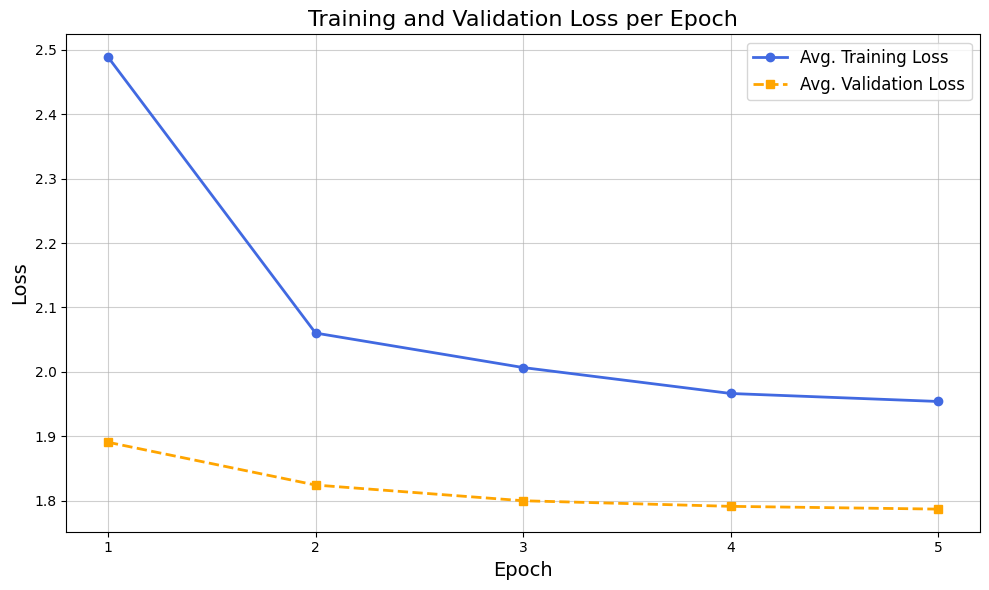

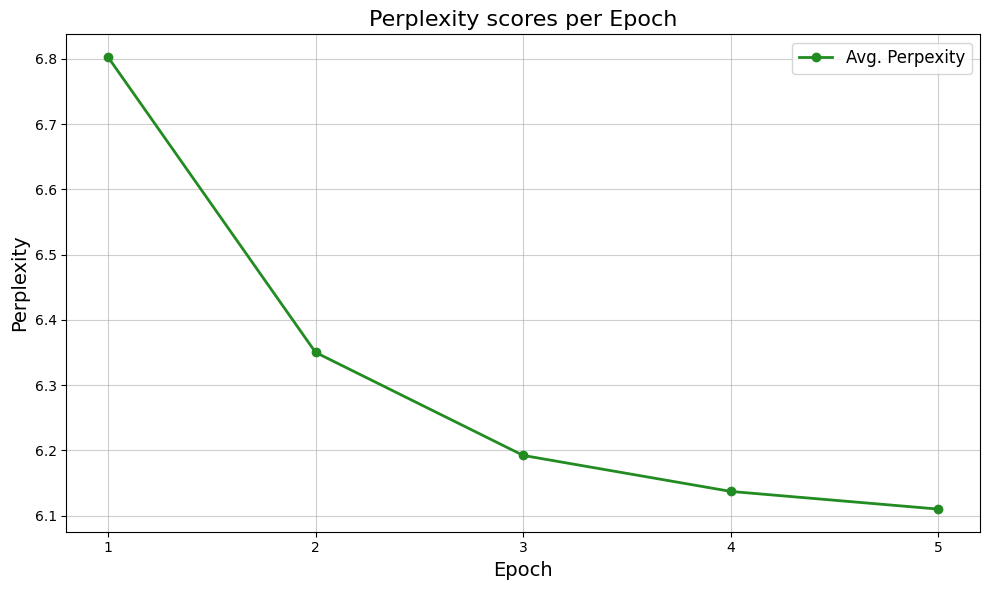

In [ ]:
# === Choose one and Train === #
prompt_and_execute_training()


## Evaluation

### Loss and Perplexity

In [ ]:
# Perplexity and Loss
def perform_model_evaluation(model: PreTrainedModel, data: DataLoader) -> Tuple[float, float]:
    """
    Computes evaluation loss and perplexity.

    Args:
        trained_model: The model to evaluate.
        data: DataLoader for evaluation data.

    Returns:
        A dictionary containing evaluation loss and perplexity.
    """
    model.eval() # Set model to evaluation mode
    model.to(device)

    loss_values = []
    perplexities = []

    for batch in tqdm(data, desc="Evaluation on Test set"):

        inputs = batch.to(device)

        with torch.no_grad():

            outputs = model(inputs, labels=inputs)
            loss = outputs.loss
            loss_values.append(loss.item())
            perplexities.append(torch.exp(loss).item())

    avg_test_loss = sum(loss_values) / len(loss_values)
    avg_test_perplexity = sum(perplexities) / len(perplexities)

    return avg_test_loss, avg_test_perplexity


# Perform evaluation on all dataset
def execute_evaluation_on_all_dataset() -> None:
    """
    Execute the evaluation process on all datasets.
    """
    for id in DATASETS_ID:
        print(f"\n>> Evaluation on {id} data...")

        # Load dataset splits
        dataset_splits = load_dataset(name=id)
        test_df = dataset_splits["test"]

        # Path to trained Model & Tokenizer
        model_tokenizer_path = os.path.join(OUTPUT_DIR, id)

        # Load Model & Tokenizer
        model, tokenizer = load_model_and_tokenizer(
            tokenizer_path=model_tokenizer_path,
            model_path=model_tokenizer_path,
        )

        # Build Test Dataset
        test_dataset = build_conversation_dataset(
            tokenizer=tokenizer,
            df=test_df,
        )

        evaluation_loader = get_dataloader(
            dataset=test_dataset,
            tokenizer=tokenizer,
            is_training=False,
        )

        # Model evaluation on Test set
        avg_loss, avg_perplexity = perform_model_evaluation(model=model, data=evaluation_loader)

        print(f"\n> Loss: {avg_loss:.4f} - Perplexity: {avg_perplexity:.4f}\n")
        # Save eval. metrics to csv
        df = pd.DataFrame({"Evaluation Loss": [avg_loss], "Evaluation Perplexity": [avg_perplexity]})
        df.to_csv(os.path.join(METRICS_DIR, f"{id}_evaluation_metrics.csv"), index=False)

        print(f"-*-"*30) # Separation line for readability


In [ ]:
# === Evaluation Process === #
execute_evaluation_on_all_dataset()



>> Evaluation on cornell data...


Evaluation on Test set:   0%|          | 0/299 [00:00<?, ?it/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.



> Loss: 1.5592 - Perplexity: 4.9392

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-

>> Evaluation on Joey data...


Evaluation on Test set:   0%|          | 0/52 [00:00<?, ?it/s]


> Loss: 1.6936 - Perplexity: 5.5974

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-

>> Evaluation on Phoebe data...


Evaluation on Test set:   0%|          | 0/47 [00:00<?, ?it/s]


> Loss: 1.7258 - Perplexity: 5.7866

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


### Emotion classification and Scores

In [ ]:
# Generate model predictions
def generate_predictions(df: pd.DataFrame, model: PreTrainedModel, tokenizer: PreTrainedTokenizer, context_column: Optional[int] = None) -> Tuple[List[str], List[str]]:
    """
    Generate model predictions from input DataFrame using provided model and tokenizer.

    Args:
        df: Input data containing context text.
        model: Pre-trained model for text generation.
        tokenizer: Tokenizer associated with the model.
        context_column: Column index for context text.

    Returns:
        List of generated prediction strings and reference.
    """
    model.eval()

    batch_size = 16
    max_new_tokens = 64

    predictions = []  # model generated responses
    full_contexts = []
    references = df["response"].tolist()

    for _, row in df.iterrows():
        if context_column is not None:
            # Use only one specific context turn
            context_value = str(row.get(f"context_{context_column}", ""))
            context_input = context_value.strip()
        else:
            # Use full multi-turn context
            context_turns = row[["context_0", "context_1", "context_2", "context_3", "context_4"]].dropna().astype(str).tolist()
            token_ids = tokenize_and_flatten_conversation(dialogue_turns=context_turns, tokenizer=tokenizer)
            context_input = tokenizer.decode(token_ids=token_ids, skip_special_tokens=True)

        full_contexts.append(context_input)

    # Batch prediction loop
    for i in tqdm(range(0, len(full_contexts), batch_size), desc="Generating Predictions"):
        batch_contexts = full_contexts[i:i + batch_size]
        encodings = tokenizer(batch_contexts, return_tensors="pt", padding=True, truncation=True)
        input_ids = encodings["input_ids"].to(device)
        attention_mask = encodings["attention_mask"].to(device)

        with torch.no_grad():
            outputs = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                pad_token_id=tokenizer.eos_token_id,
                max_new_tokens=max_new_tokens,
                top_k=100,
                top_p=0.7,
                do_sample=True,
                temperature=0.8,
                no_repeat_ngram_size=3,
            )

        # Decode outputs
        for output in outputs:
            predictions.append(tokenizer.decode(output, skip_special_tokens=True))

    return predictions, references


# Load classifier and get emotion scores
def get_emotion_scores(input: list[str]) -> np.ndarray:
    """
    Compute emotion scores for a list of texts using a pre-trained classifier.

    Args:
        input: List of input text strings.

    Returns:
        Array of shape (len(texts), len(EMOTION_LABELS)), where each row contains
        the emotion score distribution for a corresponding text.
    """
    # Initialize
    all_scores = np.zeros((len(input), len(EMOTION_LABELS)))

    # Emotion classification pipeline
    emotion_classifier = pipeline(
        task="text-classification",
        model=EMOTION_MODEL,
        batch_size=8,
        device=device,
        return_all_scores=True,
        truncation=True,
    )

    for i, text in enumerate(input):
        result = emotion_classifier(str(text))[0]  # Get emotion scores
        scores = {item["label"].lower(): item["score"] for item in result}

        # Map emotion scores to the correct index
        for j, label in enumerate(EMOTION_LABELS):
            all_scores[i, j] = scores.get(label, 0)

    return all_scores


# Define personality scoring function
def get_personality_scores(input_texts: List[str]) -> np.ndarray:

    tokenizer = AutoTokenizer.from_pretrained(BIG5_MODEL)
    model = AutoModelForSequenceClassification.from_pretrained(BIG5_MODEL).to(device)

    model.eval()

    all_scores = np.zeros((len(input_texts), len(TRAIT_LABELS)))

    with torch.no_grad():
        for i, text in enumerate(input_texts):
            text = str(text) # Ensure the text is a string before processing
            if not text.strip():
                continue
            inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt").to(device)
            outputs = model(**inputs)
            predictions = outputs.logits.squeeze().cpu().numpy()
            all_scores[i] = predictions

    return all_scores


In [ ]:
# Generate predictions based on dataset
def evaluate_on_predictions_all_dataset() -> None:
    """
    Generate predictions for all datasets and store them.
    """
    for id in DATASETS_ID:
        print(f"\n>> Predicts on {id} data...")

        # Load dataset splits
        dataset_splits = load_dataset(name=id)
        test_df = dataset_splits["test"]

        # Path to trained Model & Tokenizer
        model_tokenizer_path = os.path.join(OUTPUT_DIR, id)

        # Load Model & Tokenizer
        model, tokenizer = load_model_and_tokenizer(
            tokenizer_path=model_tokenizer_path,
            model_path=model_tokenizer_path,
        )
        tokenizer.padding_side = DEFAULT_PADDING_SIDE

        # Generate prediction
        predictions, references = generate_predictions(df=test_df, model=model, tokenizer=tokenizer, context_column=0)
        # print(f"\n> PRED: {predictions}")
        # print(f"> REF: {references}\n")

        # Compute metrics
        print(f"\n> Compute metrics: ")
        score = compute_bleu_rouge(predictions=predictions, references=references)
        bleu_rouge_scores_to_csv(data_id=id, bleu=score["BLEU"], rouge=score["ROUGE-L"])
        print(f" -- BLEU: {score['BLEU']:.4f} - ROUGE-L: {score['ROUGE-L']:.4f} - BERTScore (F1): {score['BERTScore-F1']:.4f}\n")

        # Emotion Classification
        ref_emo_scores = get_emotion_scores(input=references)
        pred_emo_scores = get_emotion_scores(input=predictions)
        avg_ref_scores = np.mean(ref_emo_scores, axis=0)
        avg_pred_scores = np.mean(pred_emo_scores, axis=0)

        # print(f"\n> Reference Emotion Scores: {avg_ref_scores}")
        # print(f"\n> Predicted Emotion Scores: {avg_pred_scores}\n")

        # Plot results
        plot_emotion_radar(
            ref_avg=avg_ref_scores,
            pred_avg=avg_pred_scores,
            labels=EMOTION_LABELS,
            save_path=os.path.join(PLOT_DIR, f"{id}_emotion_radar_plot.png"),
            id=id,
        )
        print(f"-*-"*30) # Separation line for readability



>> Predicts on cornell data...


Generating Predictions:   0%|          | 0/299 [00:00<?, ?it/s]


> Compute metrics: 


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



> Metrics saved to: /content/drive/MyDrive/Colab_Notebooks/data/metrics/cornell_predicts_metrics.csv
 -- BLEU: 0.0012 - ROUGE-L: 0.0901 - BERTScore (F1): 0.1077



Device set to use cuda
Device set to use cuda


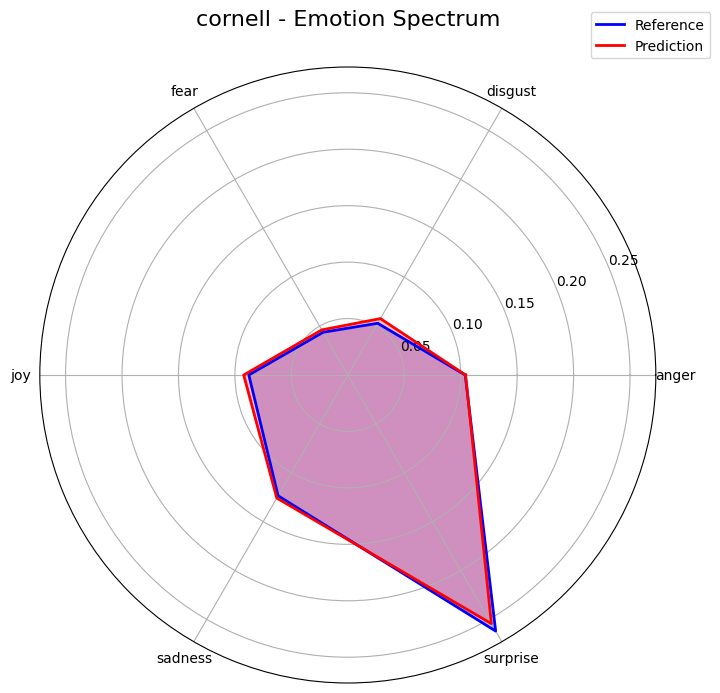

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-

>> Predicts on Joey data...


Generating Predictions:   0%|          | 0/52 [00:00<?, ?it/s]


> Compute metrics: 


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



> Metrics saved to: /content/drive/MyDrive/Colab_Notebooks/data/metrics/Joey_predicts_metrics.csv
 -- BLEU: 0.0034 - ROUGE-L: 0.0882 - BERTScore (F1): 0.1196



Device set to use cuda
Device set to use cuda


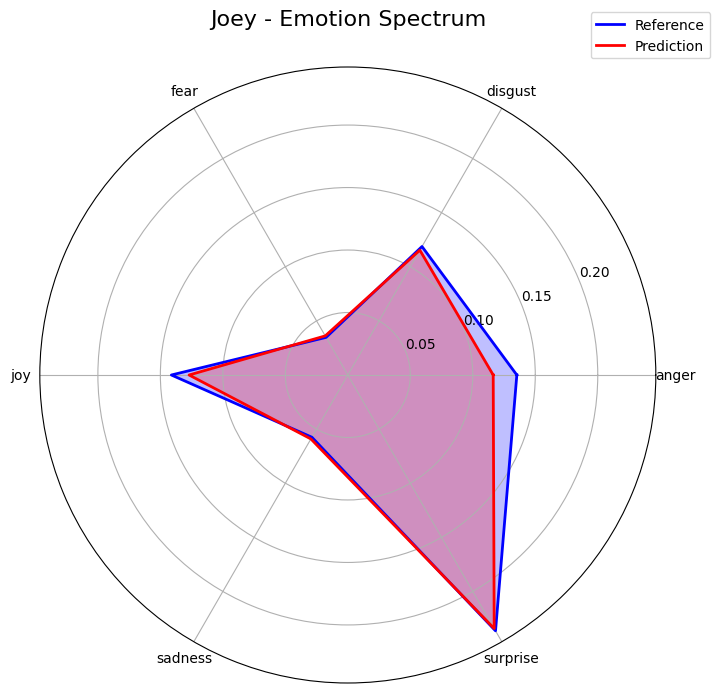

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-

>> Predicts on Phoebe data...


Generating Predictions:   0%|          | 0/47 [00:00<?, ?it/s]


> Compute metrics: 


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



> Metrics saved to: /content/drive/MyDrive/Colab_Notebooks/data/metrics/Phoebe_predicts_metrics.csv
 -- BLEU: 0.0026 - ROUGE-L: 0.0836 - BERTScore (F1): 0.1031



Device set to use cuda
Device set to use cuda


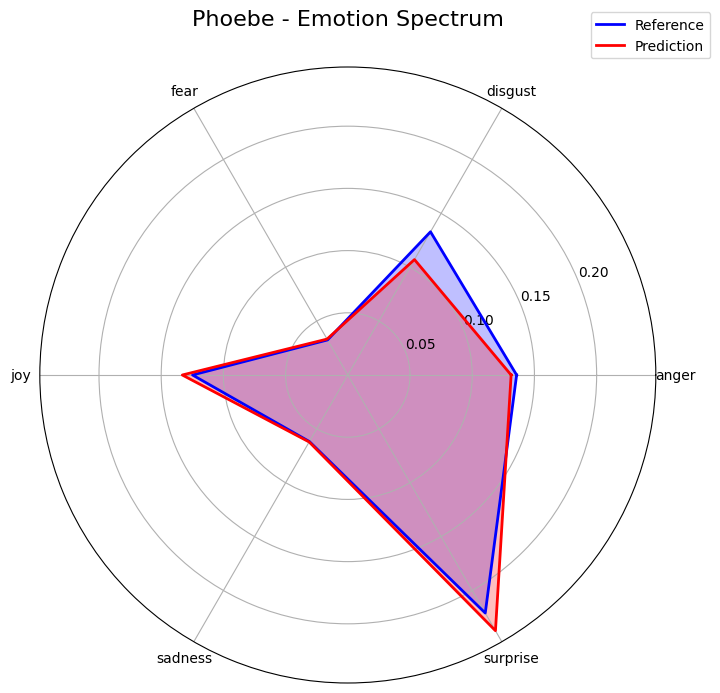

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


In [ ]:
# === Predictions for all datasets === #
evaluate_on_predictions_all_dataset()


## Chat with Bot

In [ ]:
# Initialize chatbot
def initialize_chatbot(model_path: str, tokenizer_path: str) -> Tuple[AutoModelForCausalLM, AutoTokenizer]:
    """
    Loads a pre-trained chatbot model and tokenizer.

    Args:
        model_path: Path to the pre-trained language model.
        tokenizer_path: Path to the corresponding tokenizer.

    Returns:
        Loaded model and tokenizer.
    """
    model = AutoModelForCausalLM.from_pretrained(model_path).to(device)
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = DEFAULT_PADDING_SIDE

    return model, tokenizer


# Generate the response
def generate_response(model: AutoModelForCausalLM, tokenizer: AutoTokenizer, messages: List[torch.Tensor], max_context: int = 5) -> torch.Tensor:
    """
    Generates a chatbot response based on the message history.

    Args:
        model: Pre-trained language model.
        tokenizer: Tokenizer used for encoding input text.
        messages: List of tokenized conversation history.
        max_context: Number of previous exchanges to consider for context. Default is 2.

    Returns:
        Generated chatbot response as tokenized text.
    """
    # Concatenate the last `max_context` messages to form input
    bot_input_ids = torch.cat([m.to(device) for m in messages[-max_context:]], dim=-1)

    # Generate response using the model
    chat_history_ids = model.generate(
        input_ids=bot_input_ids,              # Message in input
        max_length=100,                       # Maximum response length
        pad_token_id=tokenizer.eos_token_id,  # Ensure padding works correctly
        top_p=0.7,                            # Nucleus sampling for diverse responses
        top_k=100,                            # Limits the sampling pool
        do_sample=True,                       # Enables non-deterministic sampling
        temperature=0.8,                      # Controls randomness (higher = more random)
        no_repeat_ngram_size=3,               # Helps to avoids repeating phrases
    )
    # Return only the newly generated response (excluding input prompt)
    return chat_history_ids[:, bot_input_ids.shape[-1]:]


# Chat with bot
def chatbot_loop(model_path: str, tokenizer_path: str) -> None:
    """
    Starts an interactive chatbot session using a pre-trained language model.

    Args:
        model_path: Path to the pre-trained model. Default is 'output_dir'.
        tokenizer_path: Path to the tokenizer. Default is 'tokenizer_name'.
    Returns:
        None
    """
    messages = [] # Store conversation history

    # Load chatbot model and tokenizer
    model, tokenizer = initialize_chatbot(
        model_path=model_path, tokenizer_path=tokenizer_path
    )
    print("\n[Chatbot initialized! Type 'bye', 'quit', or 'exit' to end the chat]")

    while True:
        # Get user input and normalize it
        user_input = input("\n>> User: ").strip().lower()

        # Exit condition
        if user_input in {"bye", "quit", "exit"}:
            print("\n>> Bot: See you soon!")
            break

        # Tokenize user input and append to conversation history
        user_input_ids = tokenizer.encode(user_input + tokenizer.eos_token, return_tensors="pt")
        messages.append(user_input_ids)

        # Generate response and update message history
        bot_response_ids = generate_response(model=model, tokenizer=tokenizer, messages=messages)
        bot_response = tokenizer.decode(bot_response_ids[0], skip_special_tokens=True)

        print(f"\n>> Bot: {bot_response}")
        messages.append(bot_response_ids)  # Add bot response to conversation history


In [ ]:
# Choose and start chatting
def prompt_and_chat() -> None:
    """
    Prompt the user to enter a valid dataset ID and execute training on it.
    Allows exiting the loop with 'exit', 'quit', or 'q'.
    """
    while True:
        print("\n> Available datasets:", ", ".join(DATASETS_ID))
        user_input = input("  Enter the dataset ID (or type 'q' to exit): ").strip()

        if user_input.lower() in {"q"}:
            print("\n> Process end by user.")
            return

        if user_input in DATASETS_ID:
            print(f"\n> Starting Chat with '{user_input}' bot...")
            model_path = os.path.join(OUTPUT_DIR, user_input)
            tokenizer_path = os.path.join(OUTPUT_DIR, user_input)
            chatbot_loop(model_path=model_path, tokenizer_path=tokenizer_path)
            return

        print(f"\n> Invalid dataset ID: '{user_input}'. Please choose from: {', '.join(DATASETS_ID)}\n")


# === Start the Chat === #
prompt_and_chat()

In [ ]:
# === Start the Chat === #
prompt_and_chat()



> Available datasets: cornell, Joey, Phoebe
  Enter the dataset ID (or type 'q' to exit): bye

> Invalid dataset ID: 'bye'. Please choose from: cornell, Joey, Phoebe


> Available datasets: cornell, Joey, Phoebe
  Enter the dataset ID (or type 'q' to exit): Phoebe

> Starting Chat with 'Phoebe' bot...

[Chatbot initialized! Type 'bye', 'quit', or 'exit' to end the chat]

>> User: Who are you

>> Bot: Phoebe, Im so sorry.

>> User: Hi. Why are you sorry?

>> Bot: Because I have to go to the bathroom.

>> User: No problem at all, go on

>> Bot: Oh, thank you.

>> User: After that, you wnat something to eat?

>> Bot: 

>> User: Pizza?

>> Bot: No.

>> User: What do you like to eat ?

>> Bot: Well, I just ordered a bunch of Chinese food, and I got a bunch.

>> User: Oh nice, well I'm really hungry too

>> Bot: Yeah, well, I'm really sorry.

>> User: why?

>> Bot: Well it's not like I'm gonna eat anything.

>> User: You need to eat something, i insist

>> Bot: I don't know.

>> User: bye



In [ ]:
# === Start the Chat === #
prompt_and_chat()
